Unique traits found: ['Epithet', 'Figurative_Speech', 'Hyperbolic_Language', 'Irony/Sarcasm', 'Loaded_language', 'Neologism']
Combined beeswarm plot saved to combined_beeswarm.png


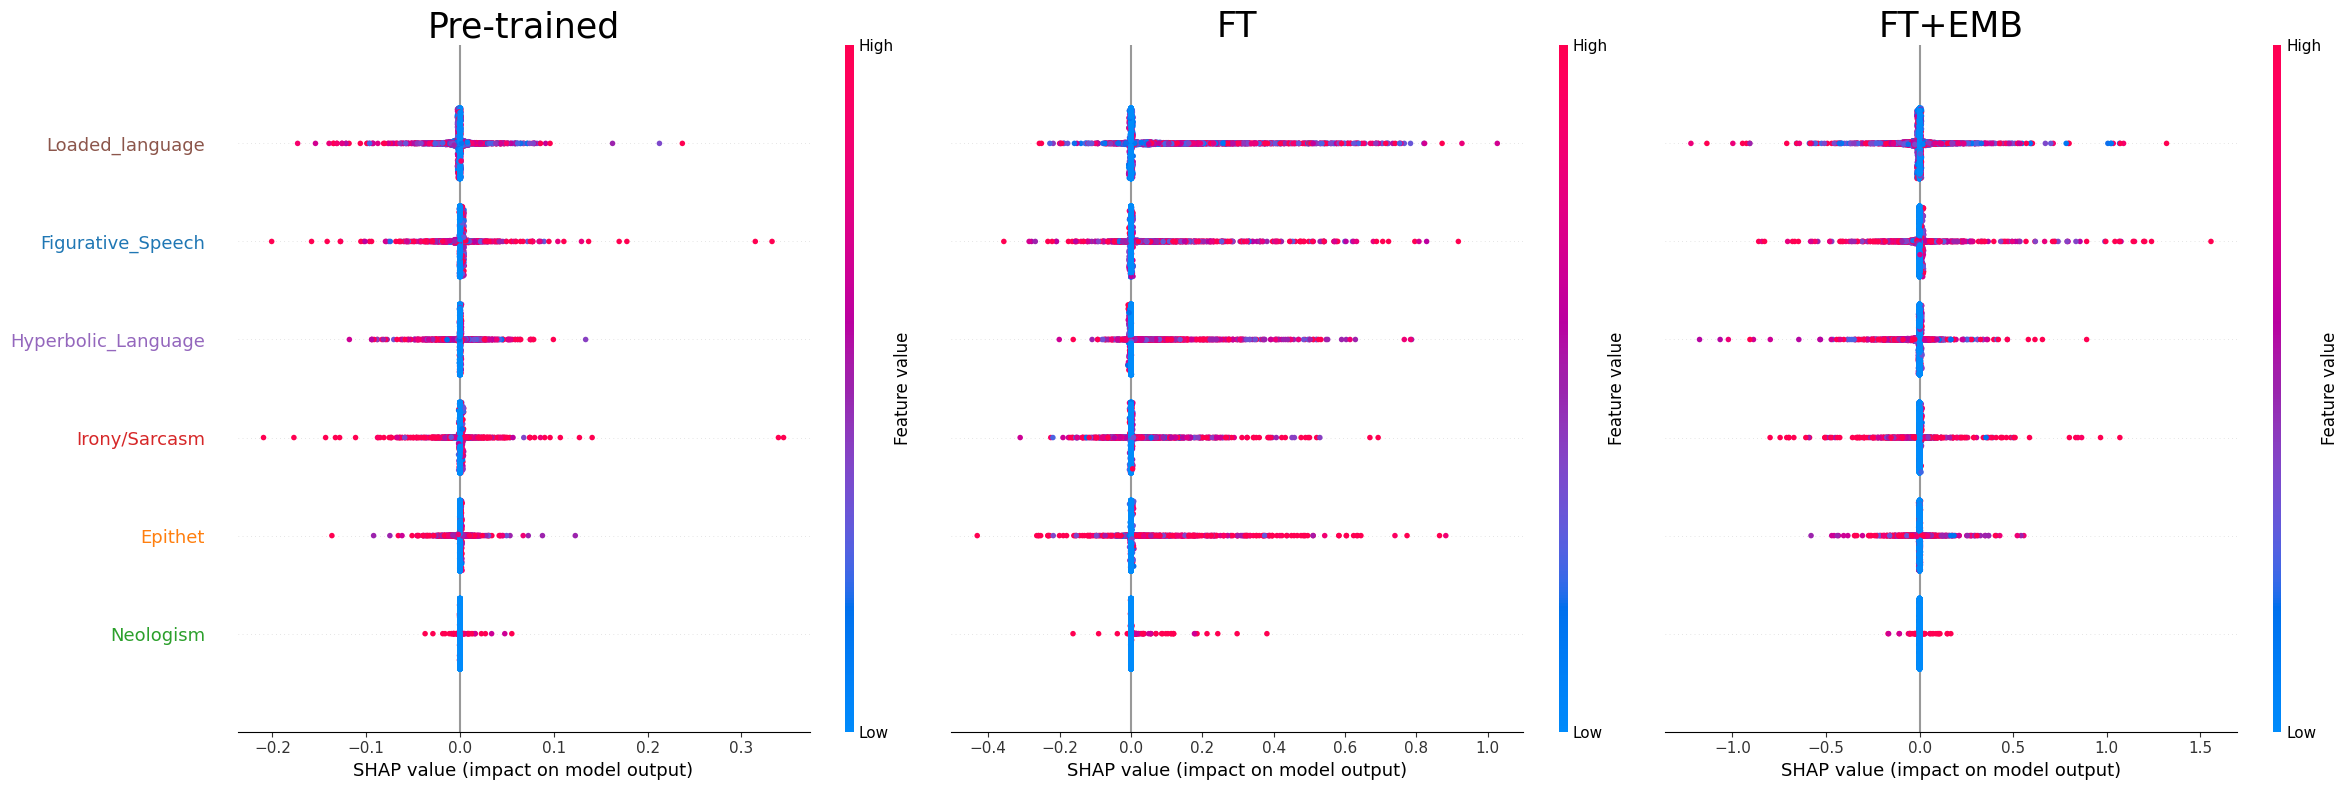

In [1]:
import pandas as pd
import ast
import numpy as np
import shap
import matplotlib.pyplot as plt

# Your trait colors
trait_colors = {
    'Figurative_Speech': '#1f77b4',  # Blue
    'Epithet': '#ff7f0e',           # Orange
    'Neologism': '#2ca02c',         # Green
    'Irony/Sarcasm': '#d62728',     # Red
    'Hyperbolic_Language': '#9467bd',  # Purple
    'Loaded_language': '#8c564b'    # Brown
}

# File paths
pretrained_path = '/home/michele.maggini/16_ottobre_GP3_SHAP_PRE_results/pretrained.csv'
ft_path = '/home/michele.maggini/XAI_HIPP/SHAP/results/FT.csv'  # Update with full path if not in current directory
ft_emb_path = '/home/michele.maggini/XAI_HIPP/SHAP/results/FT_EMB.csv'

# Load the CSVs
dfs = [
    (pd.read_csv(pretrained_path), 'Pre-trained'),
    (pd.read_csv(ft_path), 'FT'),
    (pd.read_csv(ft_emb_path), 'FT+EMB')
]

# Function to parse shap_values string into numpy array
def parse_shap_values(s, row_idx, df_name):
    try:
        # Clean string: remove brackets, replace newlines with spaces, strip
        s = s.strip('[]').replace('\n', ' ').strip()
        # Split by spaces and clean each value
        values = [v.strip(',').strip() for v in s.split() if v.strip(',')]
        # Convert to float, handle invalid values
        parsed_values = []
        for v in values:
            try:
                parsed_values.append(float(v))
            except ValueError:
                print(f"Warning: Could not convert value '{v}' to float in row {row_idx} of {df_name}")
                continue
        return np.array(parsed_values)
    except Exception as e:
        print(f"Error parsing shap_values in row {row_idx} of {df_name}: {e}")
        return np.array([])  # Return empty array to skip row

# Extract unique traits from token_trait_mapping across all dataframes (excluding 'non-trait')
all_traits = set()
for df, df_name in dfs:
    for i, mapping_str in enumerate(df['token_trait_mapping']):
        try:
            mapping = ast.literal_eval(mapping_str)
            for traits in mapping:
                for t in traits:
                    if t != 'non-trait':
                        all_traits.add(t)
        except Exception as e:
            print(f"Error parsing token_trait_mapping in row {i} of {df_name}: {e}")
            continue

trait_list = sorted(all_traits)
print("Unique traits found:", trait_list)

# Function to process a dataframe into SHAP Explanation
def process_df_to_explanation(df, df_name):
    n_samples = len(df)
    n_features = len(trait_list)
    shap_matrix = np.zeros((n_samples, n_features))
    feature_values = np.zeros((n_samples, n_features))  # Count of tokens with each trait
    base_values = df['base_value'].values
    skipped_rows = []

    for i in range(n_samples):
        try:
            shap_vals = parse_shap_values(df['shap_values'][i], i, df_name)
            mapping = ast.literal_eval(df['token_trait_mapping'][i])
            if len(shap_vals) == 0:  # Skip if shap_values parsing failed
                skipped_rows.append(i)
                continue
            if len(shap_vals) != len(mapping):
                print(f"Length mismatch in row {i} of {df_name}: shap {len(shap_vals)}, mapping {len(mapping)}")
                skipped_rows.append(i)
                continue
            for j, traits in enumerate(mapping):
                for t in traits:
                    if t != 'non-trait' and t in trait_list:
                        idx = trait_list.index(t)
                        shap_matrix[i, idx] += shap_vals[j]
                        feature_values[i, idx] += 1  # Count occurrences
        except Exception as e:
            print(f"Error processing row {i} in {df_name}: {e}")
            skipped_rows.append(i)
            continue

    if skipped_rows:
        print(f"Skipped rows in {df_name}: {skipped_rows}")

    explanation = shap.Explanation(
        values=shap_matrix,
        base_values=base_values,
        data=feature_values,
        feature_names=trait_list
    )
    return explanation

# Process each dataframe
explanations = [(process_df_to_explanation(df, label), label) for df, label in dfs]

# Create a single figure with 3 subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)  # Increased figsize for clarity

for i, (expl, label) in enumerate(explanations):
    shap.plots.beeswarm(expl, ax=axs[i], plot_size=None, show=False)  # Set plot_size=None
    axs[i].set_title(label, fontsize=25)
    
    # Customize feature label colors using trait_colors dict
    for text in axs[i].get_yticklabels():
        trait = text.get_text()
        if trait in trait_colors:
            text.set_color(trait_colors[trait])

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('combined_beeswarm.png', dpi=300, bbox_inches='tight')
print('Combined beeswarm plot saved to combined_beeswarm.png')

Unique traits found: ['Epithet', 'Figurative_Speech', 'Hyperbolic_Language', 'Irony/Sarcasm', 'Loaded_language', 'Neologism', 'non-trait']
Combined beeswarm plot saved to combined_beeswarm.png


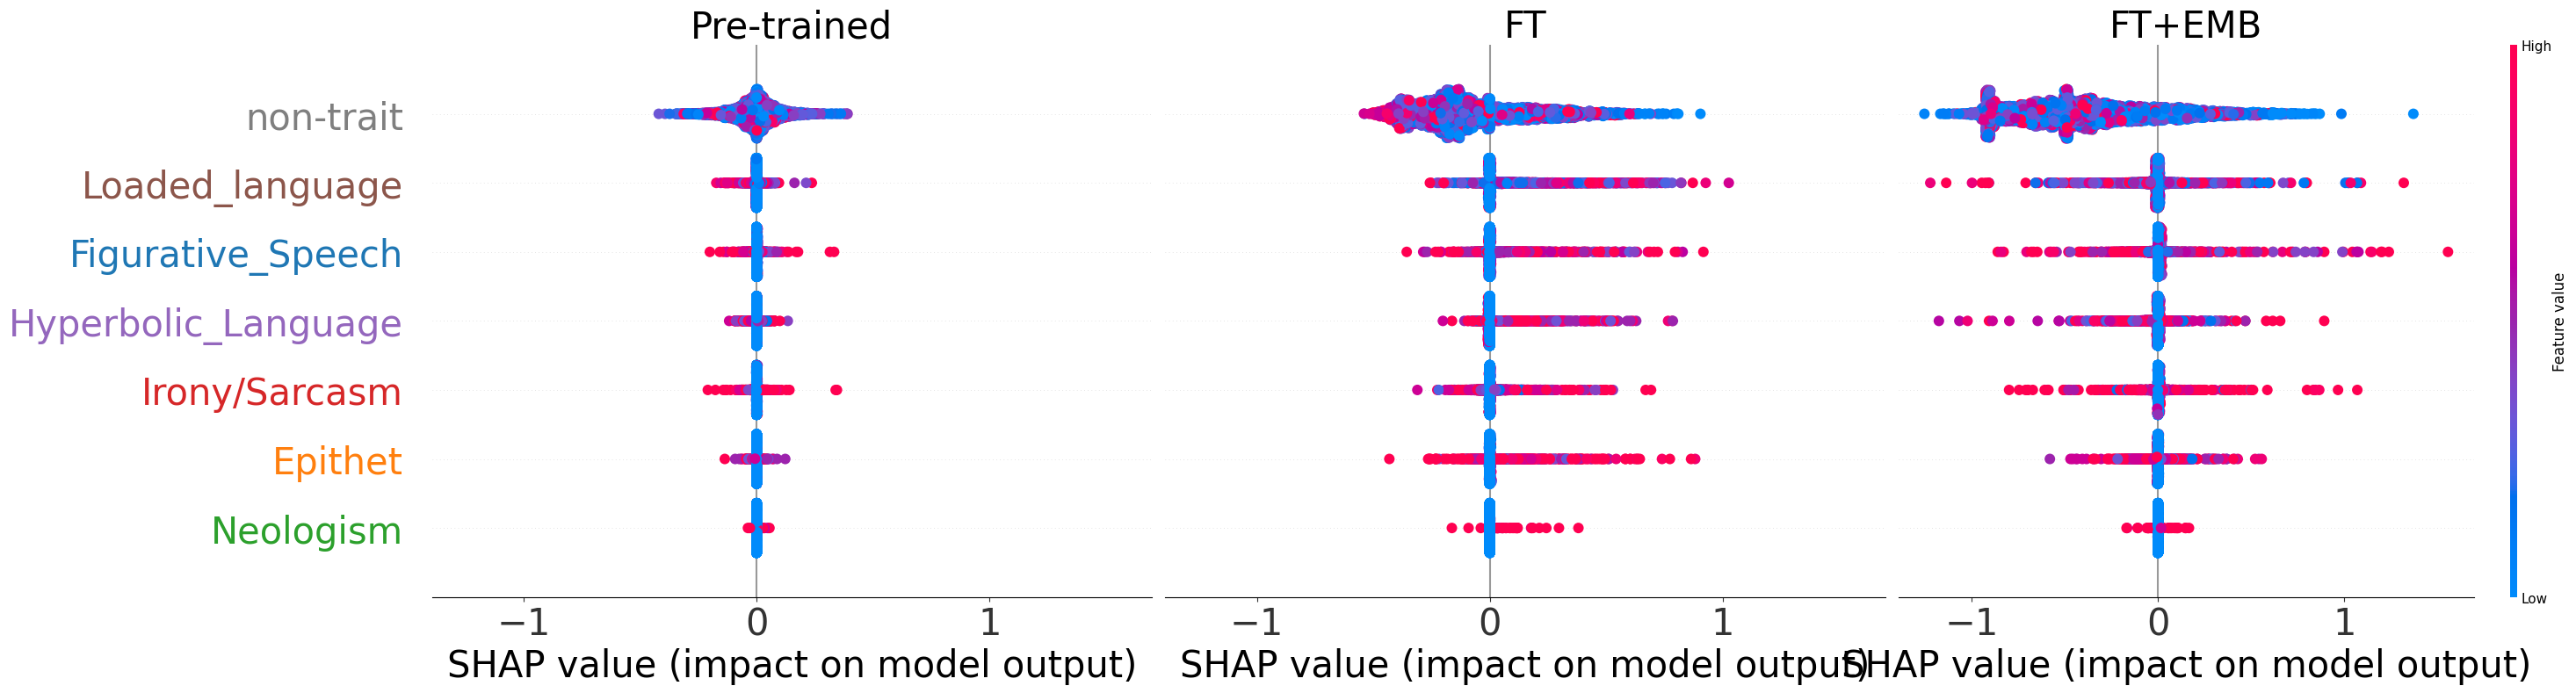

In [57]:
import pandas as pd
import ast
import numpy as np
import shap
import matplotlib.pyplot as plt

# Your trait colors (including 'non-trait')
trait_colors = {
    'Figurative_Speech': '#1f77b4',  # Blue
    'Epithet': '#ff7f0e',           # Orange
    'Neologism': '#2ca02c',         # Green
    'Irony/Sarcasm': '#d62728',     # Red
    'Hyperbolic_Language': '#9467bd',  # Purple
    'Loaded_language': '#8c564b',   # Brown
    'non-trait': '#7f7f7f'          # Gray for non-trait
}


# Load the CSVs
dfs = [
    (pd.read_csv(pretrained_path), 'Pre-trained'),
    (pd.read_csv(ft_path), 'FT'),
    (pd.read_csv(ft_emb_path), 'FT+EMB')
]

# Function to parse shap_values string into numpy array
def parse_shap_values(s, row_idx, df_name):
    try:
        # Clean string: remove brackets, replace newlines with spaces, strip
        s = s.strip('[]').replace('\n', ' ').strip()
        # Split by spaces and clean each value
        values = [v.strip(',').strip() for v in s.split() if v.strip(',')]
        # Convert to float, handle invalid values
        parsed_values = []
        for v in values:
            try:
                parsed_values.append(float(v))
            except ValueError:
                print(f"Warning: Could not convert value '{v}' to float in row {row_idx} of {df_name}")
                continue
        return np.array(parsed_values)
    except Exception as e:
        print(f"Error parsing shap_values in row {row_idx} of {df_name}: {e}")
        return np.array([])  # Return empty array to skip row

# Extract unique traits from token_trait_mapping across all dataframes (including 'non-trait')
all_traits = set()
for df, df_name in dfs:
    for i, mapping_str in enumerate(df['token_trait_mapping']):
        try:
            mapping = ast.literal_eval(mapping_str)
            for traits in mapping:
                for t in traits:
                    all_traits.add(t)  # Include 'non-trait'
        except Exception as e:
            print(f"Error parsing token_trait_mapping in row {i} of {df_name}: {e}")
            continue

trait_list = sorted(all_traits)
print("Unique traits found:", trait_list)

# Function to process a dataframe into SHAP Explanation and return shap_matrix for x-axis scaling
def process_df_to_explanation(df, df_name):
    n_samples = len(df)
    n_features = len(trait_list)
    shap_matrix = np.zeros((n_samples, n_features))
    feature_values = np.zeros((n_samples, n_features))  # Count of tokens with each trait
    base_values = df['base_value'].values
    skipped_rows = []

    for i in range(n_samples):
        try:
            shap_vals = parse_shap_values(df['shap_values'][i], i, df_name)
            mapping = ast.literal_eval(df['token_trait_mapping'][i])
            if len(shap_vals) == 0:  # Skip if shap_values parsing failed
                skipped_rows.append(i)
                continue
            if len(shap_vals) != len(mapping):
                print(f"Length mismatch in row {i} of {df_name}: shap {len(shap_vals)}, mapping {len(mapping)}")
                skipped_rows.append(i)
                continue
            for j, traits in enumerate(mapping):
                for t in traits:
                    if t in trait_list:  # Include 'non-trait' in aggregation
                        idx = trait_list.index(t)
                        shap_matrix[i, idx] += shap_vals[j]
                        feature_values[i, idx] += 1  # Count occurrences
        except Exception as e:
            print(f"Error processing row {i} in {df_name}: {e}")
            skipped_rows.append(i)
            continue

    if skipped_rows:
        print(f"Skipped rows in {df_name}: {skipped_rows}")

    explanation = shap.Explanation(
        values=shap_matrix,
        base_values=base_values,
        data=feature_values,
        feature_names=trait_list
    )
    return explanation, shap_matrix

# Process each dataframe and collect shap_matrices for x-axis scaling
explanations = []
shap_matrices = []
for df, label in dfs:
    expl, shap_matrix = process_df_to_explanation(df, label)
    explanations.append((expl, label))
    shap_matrices.append(shap_matrix)

# Calculate global x-axis limits
all_shap_values = np.concatenate([m.flatten() for m in shap_matrices])
x_min, x_max = np.min(all_shap_values), np.max(all_shap_values)
# Add a small margin (e.g., 5%) to make the plot look cleaner
margin = (x_max - x_min) * 0.05
x_limits = (x_min - margin, x_max + margin)

# Create a single figure with 3 subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(30, 8), sharey=True)  # Adjusted figsize for clarity

for i, (expl, label) in enumerate(explanations):
    # Show color bar only for the last subplot (FT+EMB)
    color_bar = (i == 2)
    shap.plots.beeswarm(expl, ax=axs[i], plot_size=None, show=False, color_bar=color_bar, s=75)
    axs[i].set_title(label, fontsize=30)
    
    # Customize axis labels and tick font sizes
    axs[i].set_xlabel("SHAP value (impact on model output)", fontsize=30)
    axs[i].tick_params(axis='x', labelsize=30)
    # Set consistent x-axis limits
    axs[i].set_xlim(x_limits)
    if i == 0:  # Only set y-label and y-tick params for the first subplot (shared y-axis)
        axs[i].set_ylabel("", fontsize=30)
        for text in axs[i].get_yticklabels():
            trait = text.get_text()
            text.set_fontsize(30)
            if trait in trait_colors:
                text.set_color(trait_colors[trait])


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot
plt.savefig('combined_beeswarm.png', dpi=300, bbox_inches='tight')
print('Combined beeswarm plot saved to combined_beeswarm.png')

Unique traits found: ['Epithet', 'Figurative_Speech', 'Hyperbolic_Language', 'Irony/Sarcasm', 'Loaded_language', 'Neologism']
Combined beeswarm plot saved to combined_beeswarm.png


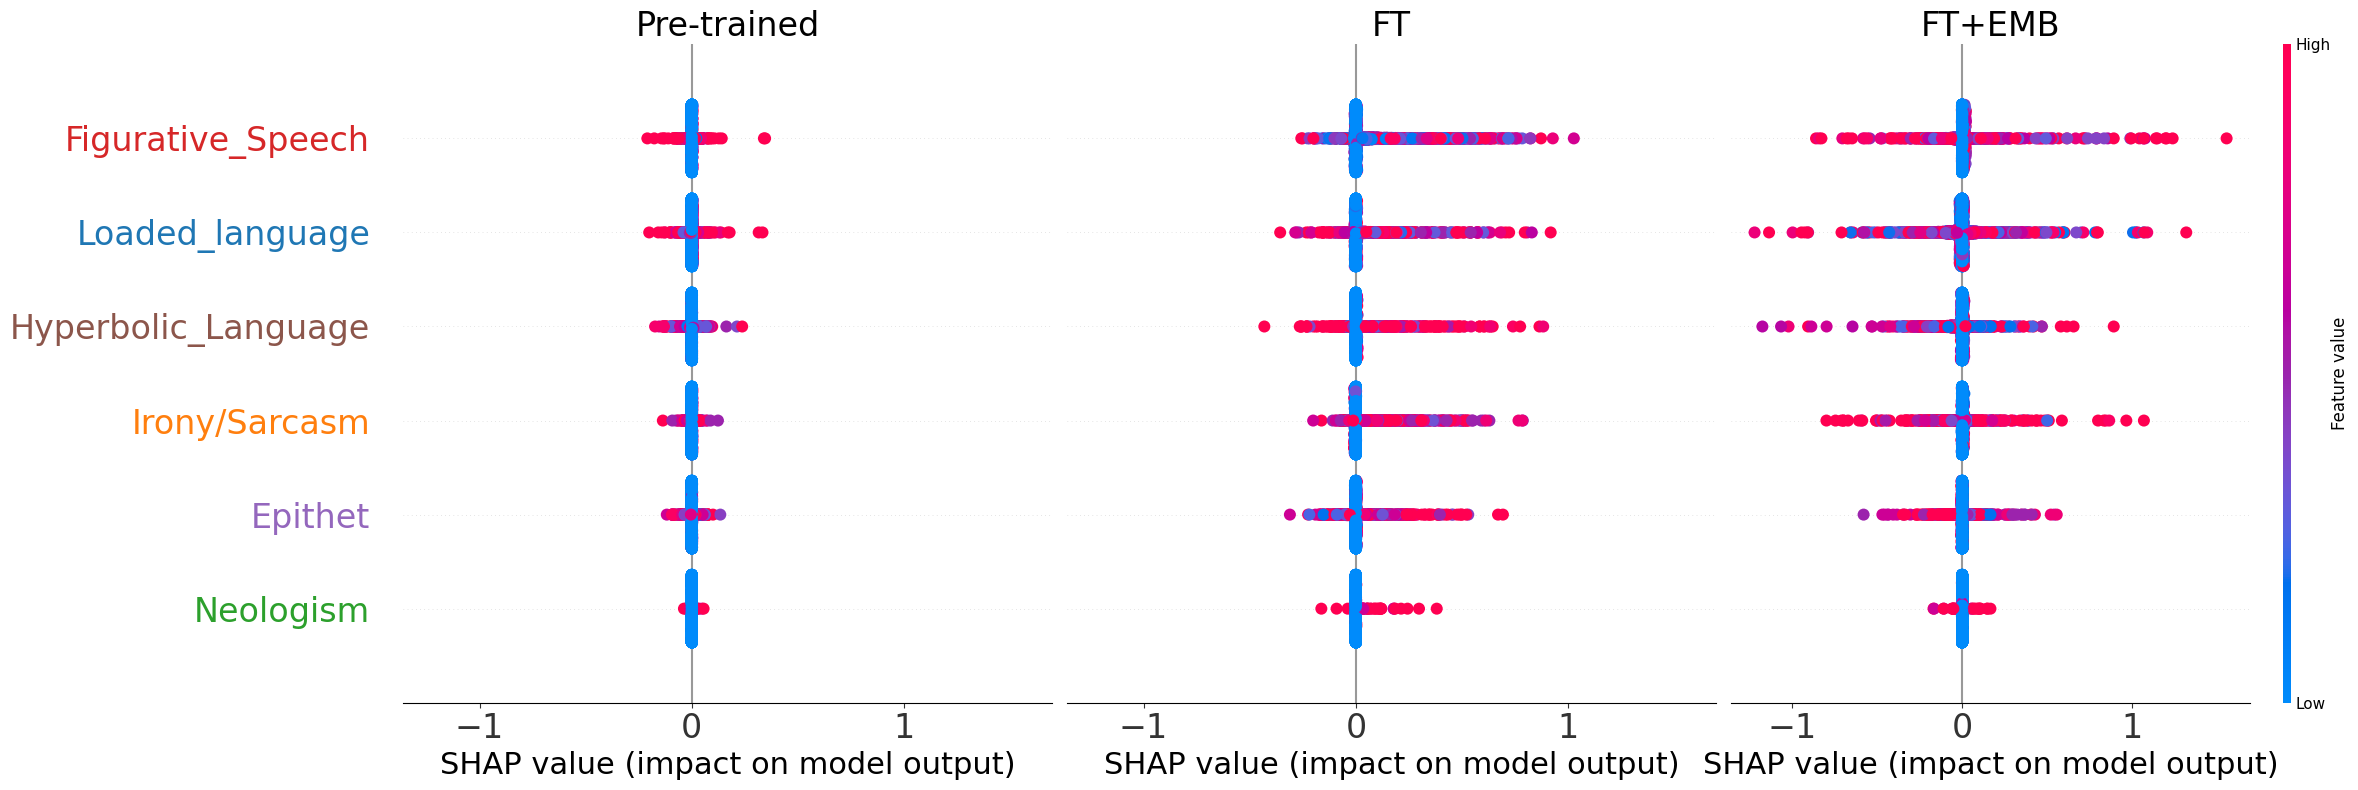

In [ ]:
import pandas as pd
import ast
import numpy as np
import shap
import matplotlib.pyplot as plt

# Your trait colors
trait_colors = {
    'Figurative_Speech': '#1f77b4',  # Blue
    'Epithet': '#ff7f0e',           # Orange
    'Neologism': '#2ca02c',         # Green
    'Irony/Sarcasm': '#d62728',     # Red
    'Hyperbolic_Language': '#9467bd',  # Purple
    'Loaded_language': '#8c564b'    # Brown
}


# Load the CSVs
dfs = [
    (pd.read_csv(pretrained_path), 'Pre-trained'),
    (pd.read_csv(ft_path), 'FT'),
    (pd.read_csv(ft_emb_path), 'FT+EMB')
]

# Function to parse shap_values string into numpy array
def parse_shap_values(s, row_idx, df_name):
    try:
        # Clean string: remove brackets, replace newlines with spaces, strip
        s = s.strip('[]').replace('\n', ' ').strip()
        # Split by spaces and clean each value
        values = [v.strip(',').strip() for v in s.split() if v.strip(',')]
        # Convert to float, handle invalid values
        parsed_values = []
        for v in values:
            try:
                parsed_values.append(float(v))
            except ValueError:
                print(f"Warning: Could not convert value '{v}' to float in row {row_idx} of {df_name}")
                continue
        return np.array(parsed_values)
    except Exception as e:
        print(f"Error parsing shap_values in row {row_idx} of {df_name}: {e}")
        return np.array([])  # Return empty array to skip row

# Extract unique traits from token_trait_mapping across all dataframes (excluding 'non-trait')
all_traits = set()
for df, df_name in dfs:
    for i, mapping_str in enumerate(df['token_trait_mapping']):
        try:
            mapping = ast.literal_eval(mapping_str)
            for traits in mapping:
                for t in traits:
                    if t != 'non-trait':
                        all_traits.add(t)
        except Exception as e:
            print(f"Error parsing token_trait_mapping in row {i} of {df_name}: {e}")
            continue

trait_list = sorted(all_traits)
print("Unique traits found:", trait_list)

# Function to process a dataframe into SHAP Explanation and return shap_matrix for x-axis scaling
def process_df_to_explanation(df, df_name):
    n_samples = len(df)
    n_features = len(trait_list)
    shap_matrix = np.zeros((n_samples, n_features))
    feature_values = np.zeros((n_samples, n_features))  # Count of tokens with each trait
    base_values = df['base_value'].values
    skipped_rows = []

    for i in range(n_samples):
        try:
            shap_vals = parse_shap_values(df['shap_values'][i], i, df_name)
            mapping = ast.literal_eval(df['token_trait_mapping'][i])
            if len(shap_vals) == 0:  # Skip if shap_values parsing failed
                skipped_rows.append(i)
                continue
            if len(shap_vals) != len(mapping):
                print(f"Length mismatch in row {i} of {df_name}: shap {len(shap_vals)}, mapping {len(mapping)}")
                skipped_rows.append(i)
                continue
            for j, traits in enumerate(mapping):
                for t in traits:
                    if t != 'non-trait' and t in trait_list:
                        idx = trait_list.index(t)
                        shap_matrix[i, idx] += shap_vals[j]
                        feature_values[i, idx] += 1  # Count occurrences
        except Exception as e:
            print(f"Error processing row {i} in {df_name}: {e}")
            skipped_rows.append(i)
            continue

    if skipped_rows:
        print(f"Skipped rows in {df_name}: {skipped_rows}")

    explanation = shap.Explanation(
        values=shap_matrix,
        base_values=base_values,
        data=feature_values,
        feature_names=trait_list
    )
    return explanation, shap_matrix

# Process each dataframe and collect shap_matrices for x-axis scaling
explanations = []
shap_matrices = []
for df, label in dfs:
    expl, shap_matrix = process_df_to_explanation(df, label)
    explanations.append((expl, label))
    shap_matrices.append(shap_matrix)

# Calculate global x-axis limits
all_shap_values = np.concatenate([m.flatten() for m in shap_matrices])
x_min, x_max = np.min(all_shap_values), np.max(all_shap_values)
# Add a small margin (e.g., 5%) to make the plot look cleaner
margin = (x_max - x_min) * 0.05
x_limits = (x_min - margin, x_max + margin)

# Create a single figure with 3 subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)  # Adjusted figsize for clarity

for i, (expl, label) in enumerate(explanations):
    # Show color bar only for the last subplot (FT+EMB)
    color_bar = (i == 2)
    shap.plots.beeswarm(expl, ax=axs[i], plot_size=None, show=False, color_bar=color_bar, s=75, order=expl.abs.max(0))
    axs[i].set_title(label, fontsize=24)
    
    # Customize axis labels and tick font sizes
    axs[i].set_xlabel("SHAP value (impact on model output)", fontsize=22)
    axs[i].tick_params(axis='x', labelsize=24)
    # Set consistent x-axis limits
    axs[i].set_xlim(x_limits)
    if i == 0:  # Only set y-label and y-tick params for the first subplot (shared y-axis)
        axs[i].set_ylabel("", fontsize=22)
        for text in axs[i].get_yticklabels():
            trait = text.get_text()
            text.set_fontsize(24)
            if trait in trait_colors:
                text.set_color(trait_colors[trait])

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot
plt.savefig('combined_beeswarm.png', dpi=300, bbox_inches='tight')
print('Combined beeswarm plot saved to combined_beeswarm.png')

Unique traits found: ['Epithet', 'Figurative_Speech', 'Hyperbolic_Language', 'Irony/Sarcasm', 'Loaded_language', 'Neologism', 'non-trait']
Combined beeswarm plot (single row) saved to combined_beeswarm_single_row.png


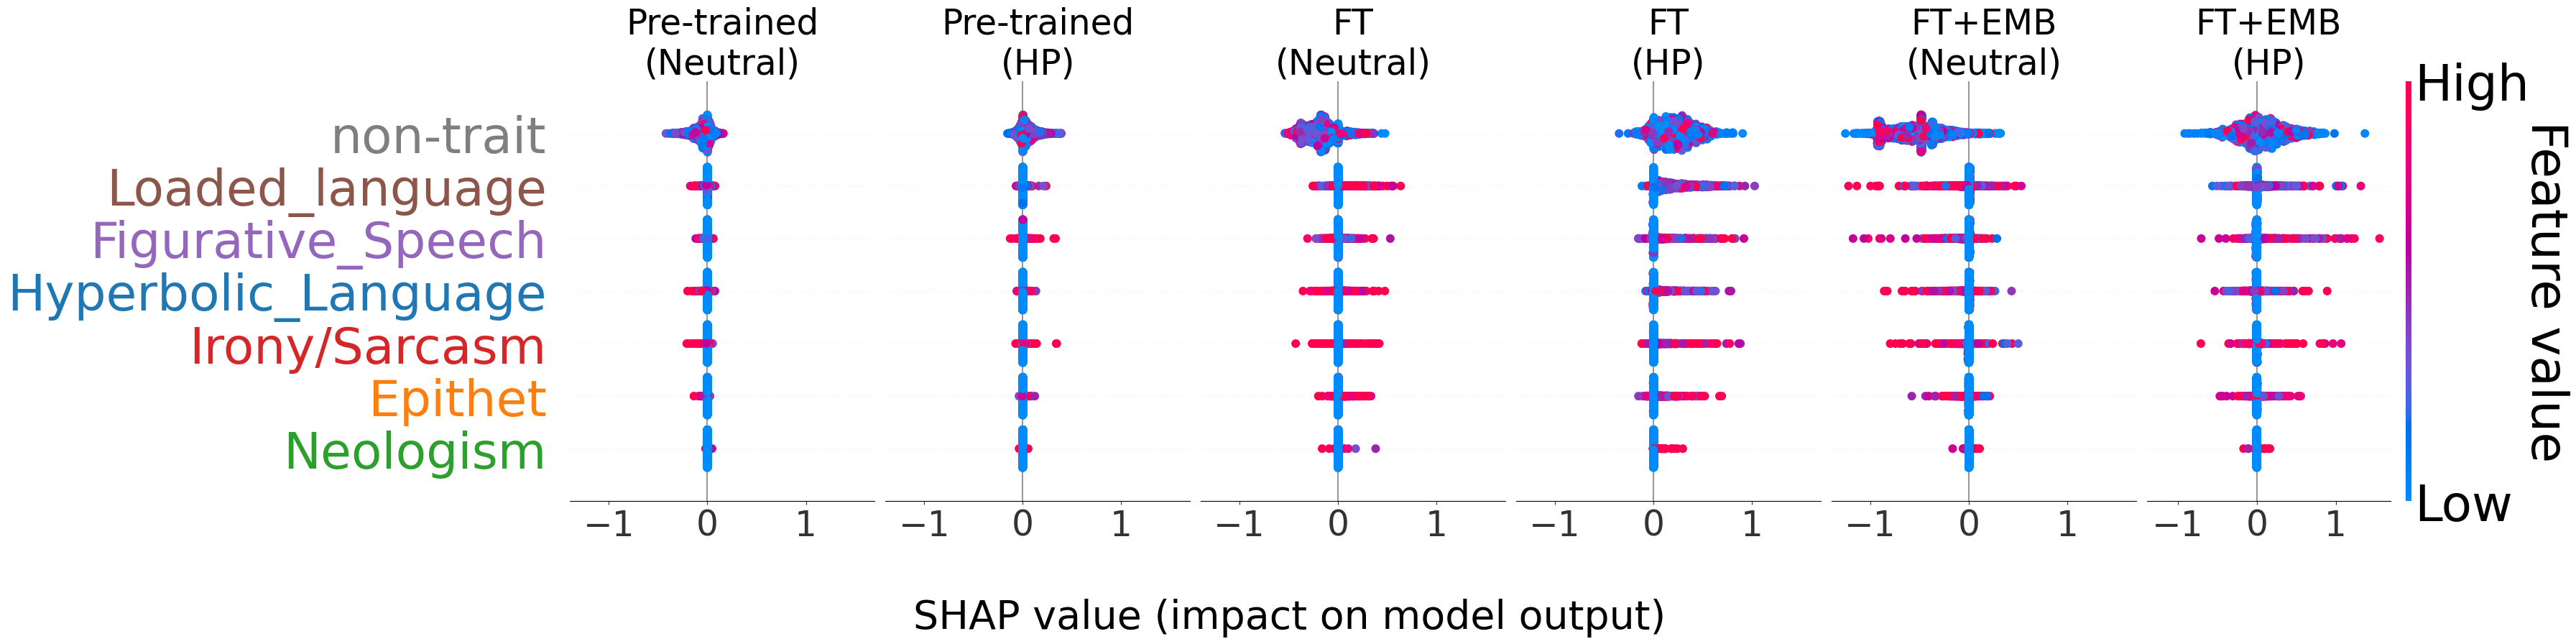

In [75]:
import pandas as pd
import ast
import numpy as np
import shap
import matplotlib.pyplot as plt

# Your trait colors (adding a color for 'non-trait')
trait_colors = {
    'Figurative_Speech': '#1f77b4',  # Blue
    'Epithet': '#ff7f0e',           # Orange
    'Neologism': '#2ca02c',         # Green
    'Irony/Sarcasm': '#d62728',     # Red
    'Hyperbolic_Language': '#9467bd',  # Purple
    'Loaded_language': '#8c564b',   # Brown
    'non-trait': '#7f7f7f'          # Gray for non-trait
}


# Function to parse shap_values string into numpy array
def parse_shap_values(s, row_idx, df_name):
    try:
        # Clean string: remove brackets, replace newlines with spaces, strip
        s = s.strip('[]').replace('\n', ' ').strip()
        # Split by spaces and clean each value
        values = [v.strip(',').strip() for v in s.split() if v.strip(',')]
        # Convert to float, handle invalid values
        parsed_values = []
        for v in values:
            try:
                parsed_values.append(float(v))
            except ValueError:
                print(f"Warning: Could not convert value '{v}' to float in row {row_idx} of {df_name}")
                continue
        return np.array(parsed_values)
    except Exception as e:
        print(f"Error parsing shap_values in row {row_idx} of {df_name}: {e}")
        return np.array([])  # Return empty array to skip row

# Function to get predicted label from label_pred string
def get_predicted_label(label_pred_str, row_idx, df_name):
    try:
        preds = ast.literal_eval(label_pred_str)
        max_entry = max(preds, key=lambda x: x['score'])
        max_label = max_entry['label']
        return 0 if max_label == 'LABEL_0' else 1
    except Exception as e:
        print(f"Error parsing label_pred in row {row_idx} of {df_name}: {e}")
        return -1  # Error flag

# Extract unique traits from token_trait_mapping across all dataframes (including 'non-trait')
all_traits = set()
for df, df_name in dfs:
    for i, mapping_str in enumerate(df['token_trait_mapping']):
        try:
            mapping = ast.literal_eval(mapping_str)
            for traits in mapping:
                for t in traits:
                    all_traits.add(t)  # Include 'non-trait' as well
        except Exception as e:
            print(f"Error parsing token_trait_mapping in row {i} of {df_name}: {e}")
            continue

trait_list = sorted(all_traits)
print("Unique traits found:", trait_list)

# Function to process a dataframe into separate SHAP Explanations for LABEL_0 and LABEL_1, and return shap_matrices
def process_df_to_explanation(df, df_name):
    n_samples = len(df)
    n_features = len(trait_list)
    shap_matrix0, feature_values0, base_values0 = [], [], []
    shap_matrix1, feature_values1, base_values1 = [], [], []
    skipped_rows = []

    for i in range(n_samples):
        try:
            pred = get_predicted_label(df['label_pred'][i], i, df_name)
            if pred == -1:
                skipped_rows.append(i)
                continue

            shap_vals = parse_shap_values(df['shap_values'][i], i, df_name)
            mapping = ast.literal_eval(df['token_trait_mapping'][i])
            if len(shap_vals) == 0:  # Skip if shap_values parsing failed
                skipped_rows.append(i)
                continue
            if len(shap_vals) != len(mapping):
                print(f"Length mismatch in row {i} of {df_name}: shap {len(shap_vals)}, mapping {len(mapping)}")
                skipped_rows.append(i)
                continue

            # Compute aggregated shap and feature values for this sample
            sample_shap = np.zeros(n_features)
            sample_features = np.zeros(n_features)
            for j, traits in enumerate(mapping):
                for t in traits:
                    if t in trait_list:  # Include 'non-trait' in aggregation
                        idx = trait_list.index(t)
                        sample_shap[idx] += shap_vals[j]
                        sample_features[idx] += 1  # Count occurrences

            if pred == 0:
                shap_matrix0.append(sample_shap)
                feature_values0.append(sample_features)
                base_values0.append(df['base_value'][i])
            elif pred == 1:
                shap_matrix1.append(sample_shap)
                feature_values1.append(sample_features)
                base_values1.append(df['base_value'][i])
        except Exception as e:
            print(f"Error processing row {i} in {df_name}: {e}")
            skipped_rows.append(i)
            continue

    if skipped_rows:
        print(f"Skipped rows in {df_name}: {skipped_rows}")

    # Create explanations if not empty
    explanation0 = None if not shap_matrix0 else shap.Explanation(
        values=np.array(shap_matrix0),
        base_values=np.array(base_values0),
        data=np.array(feature_values0),
        feature_names=trait_list
    )
    explanation1 = None if not shap_matrix1 else shap.Explanation(
        values=np.array(shap_matrix1),
        base_values=np.array(base_values1),
        data=np.array(feature_values1),
        feature_names=trait_list
    )

    return (explanation0, explanation1), (np.array(shap_matrix0) if shap_matrix0 else np.array([]), np.array(shap_matrix1) if shap_matrix1 else np.array([]))

# Process each dataframe and collect explanations and shap_matrices
model_explanations = []
shap_matrices_all = []
for df, label in dfs:
    (expl0, expl1), (matrix0, matrix1) = process_df_to_explanation(df, label)
    model_explanations.append(((expl0, 'Neutral'), (expl1, 'HP'), label))
    shap_matrices_all.extend([matrix0.flatten(), matrix1.flatten()])

# Calculate global x-axis limits
all_shap_values = np.concatenate([m for m in shap_matrices_all if m.size > 0])
if all_shap_values.size > 0:
    x_min, x_max = np.min(all_shap_values), np.max(all_shap_values)
    margin = (x_max - x_min) * 0.05
    x_limits = (x_min - margin, x_max + margin)
else:
    x_limits = (-1, 1)  # Default if no data

# Create a single figure with 1 row and 6 columns (3 models × 2 labels each)
fig, axs = plt.subplots(1, 6, figsize=(36, 8), sharey=True, sharex=True)

# Flatten for easier indexing
plot_idx = 0

for j, ((expl0, label0), (expl1, label1), model_label) in enumerate(model_explanations):
    # Plot for LABEL_0
    if expl0 is not None:
        shap.plots.beeswarm(expl0, ax=axs[plot_idx], plot_size=None, show=False, color_bar=False, s=75)
    axs[plot_idx].set_title(f"{model_label}\n({label0})", fontsize=35)
    axs[plot_idx].set_xlabel("")  # Remove individual x-labels
    axs[plot_idx].tick_params(axis='x', labelsize=35)
    axs[plot_idx].set_xlim(x_limits)
    
    # Only show y-axis label on first subplot
    if plot_idx == 0:
        axs[plot_idx].set_ylabel("")
        for text in axs[plot_idx].get_yticklabels():
            trait = text.get_text()
            text.set_fontsize(50)
            if trait in trait_colors:
                text.set_color(trait_colors[trait])
    
    plot_idx += 1
    
    # Plot for LABEL_1
    color_bar = (plot_idx == 5)  # Show color bar only on last subplot
    if expl1 is not None:
        shap.plots.beeswarm(expl1, ax=axs[plot_idx], plot_size=None, show=False, color_bar=color_bar, s=75)
    axs[plot_idx].set_title(f"{model_label}\n({label1})", fontsize=35)
    axs[plot_idx].set_xlabel("")  # Remove individual x-labels
    axs[plot_idx].tick_params(axis='x', labelsize=35)
    axs[plot_idx].set_xlim(x_limits)
    
    plot_idx += 1

# NOW customize the colorbar AFTER all plots are created
# The colorbar is the last axes added to the figure
for ax in fig.get_axes():
    # Check if this is a colorbar axes (they have specific properties)
    if ax.get_label() == '<colorbar>' or ax.get_position().width < 0.05:
        ax.tick_params(labelsize=50)
        ax.set_ylabel("Feature value", fontsize=50, rotation=270, labelpad=40)
        break

# Add a single centered x-label for the entire figure
fig.text(0.5, -0.1, 'SHAP value (impact on model output)', ha='center', fontsize=40)

# Adjust layout to prevent overlap and make room for the common x-label
plt.tight_layout(rect=[0, 0.03, 1, 1])  # Leave space at bottom for x-label

# Save the plot
plt.savefig('combined_beeswarm_single_row.png', dpi=300, bbox_inches='tight')
print('Combined beeswarm plot (single row) saved to combined_beeswarm_single_row.png')

Unique traits found: ['Epithet', 'Figurative_Speech', 'Hyperbolic_Language', 'Irony/Sarcasm', 'Loaded_language', 'Neologism', 'non-trait']
Pre-trained: shap_matrix0 rows=2436, indices0=2436
Pre-trained: shap_matrix1 rows=2429, indices1=2429
FT: shap_matrix0 rows=3709, indices0=3709
FT: shap_matrix1 rows=1156, indices1=1156
FT+EMB: shap_matrix0 rows=3567, indices0=3567
FT+EMB: shap_matrix1 rows=1298, indices1=1298
Processing outliers for Pre-trained, LABEL_0: matrix0 shape=(2436, 7), idx0 length=2436
Processing outliers for Pre-trained, LABEL_1: matrix1 shape=(2429, 7), idx1 length=2429
Processing outliers for FT, LABEL_0: matrix0 shape=(3709, 7), idx0 length=3709
Processing outliers for FT, LABEL_1: matrix1 shape=(1156, 7), idx1 length=1156
Processing outliers for FT+EMB, LABEL_0: matrix0 shape=(3567, 7), idx0 length=3567
Processing outliers for FT+EMB, LABEL_1: matrix1 shape=(1298, 7), idx1 length=1298

Outlier Information:

Model: Pre-trained, Label: Neutral (LABEL_0), Row Index: 0
T

AttributeError: 'Axes' object has no attribute 'pie_idx'

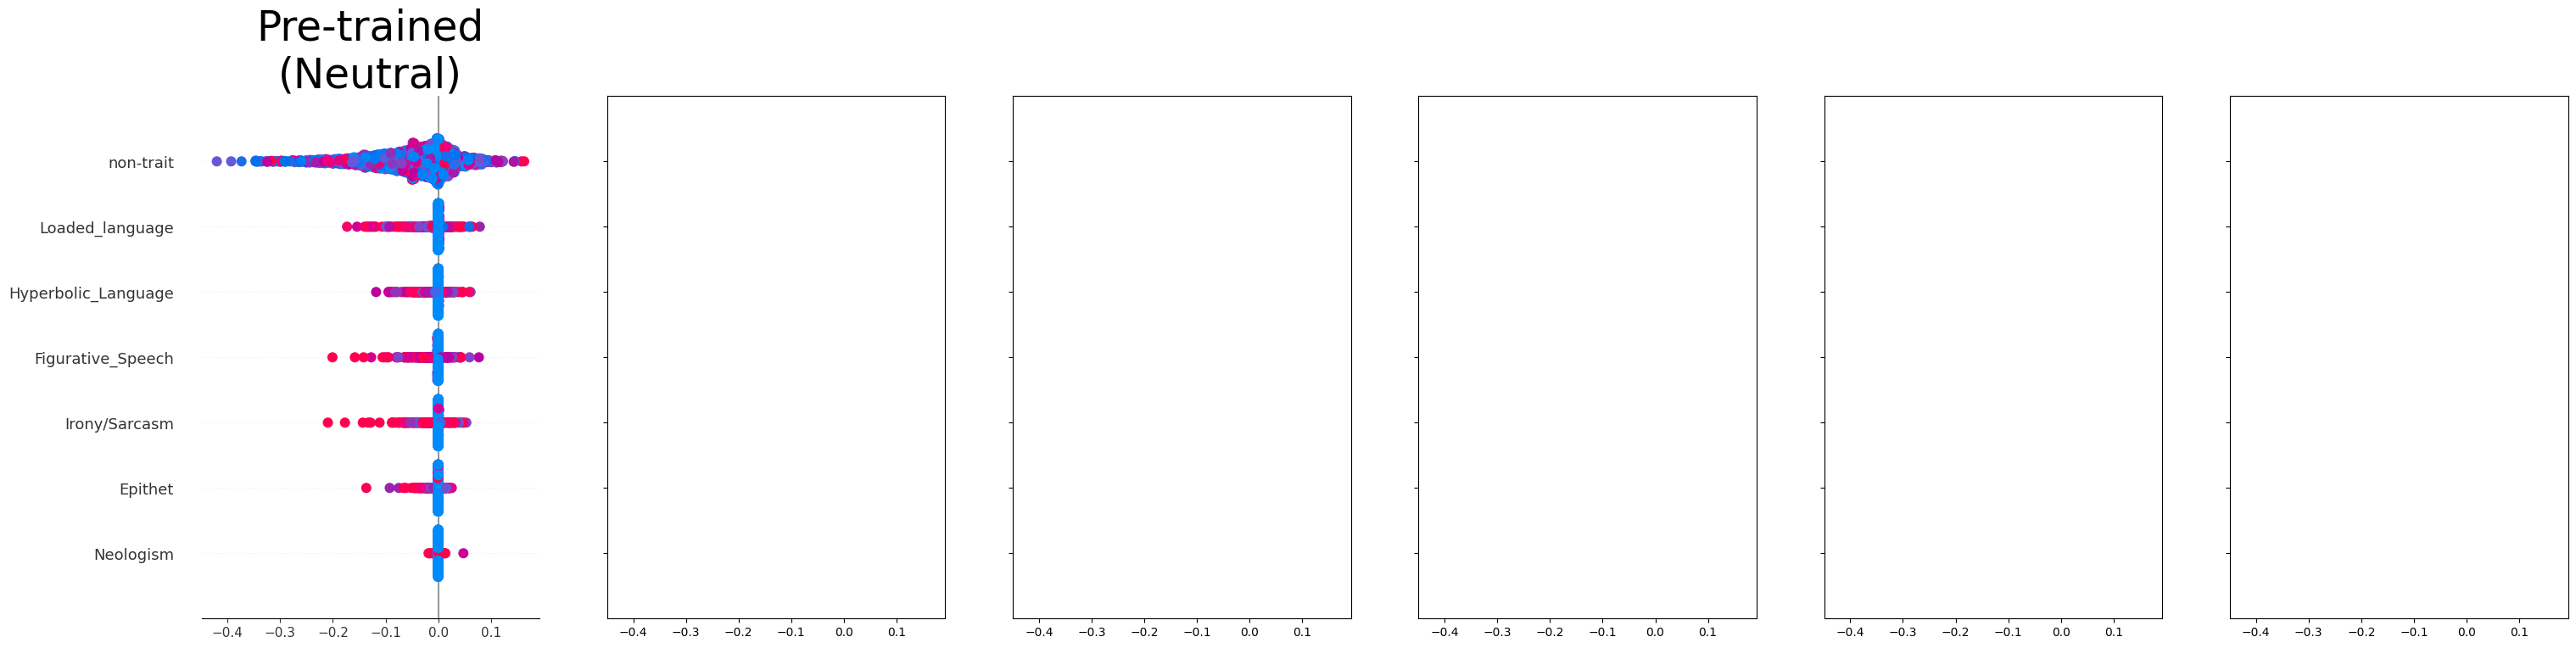

In [4]:
import pandas as pd
import ast
import numpy as np
import shap
import matplotlib.pyplot as plt

# Your trait colors (unchanged)
trait_colors = {
    'Figurative_Speech': '#1f77b4',
    'Epithet': '#ff7f0e',
    'Neologism': '#2ca02c',
    'Irony/Sarcasm': '#d62728',
    'Hyperbolic_Language': '#9467bd',
    'Loaded_language': '#8c564b',
    'non-trait': '#7f7f7f'
}

# Function to parse shap_values (unchanged)
def parse_shap_values(s, row_idx, df_name):
    try:
        s = s.strip('[]').replace('\n', ' ').strip()
        values = [v.strip(',').strip() for v in s.split() if v.strip(',')]
        parsed_values = []
        for v in values:
            try:
                parsed_values.append(float(v))
            except ValueError:
                print(f"Warning: Could not convert value '{v}' to float in row {row_idx} of {df_name}")
                continue
        return np.array(parsed_values)
    except Exception as e:
        print(f"Error parsing shap_values in row {row_idx} of {df_name}: {e}")
        return np.array([])

# Function to get predicted label (unchanged)
def get_predicted_label(label_pred_str, row_idx, df_name):
    try:
        preds = ast.literal_eval(label_pred_str)
        max_entry = max(preds, key=lambda x: x['score'])
        max_label = max_entry['label']
        return 0 if max_label == 'LABEL_0' else 1
    except Exception as e:
        print(f"Error parsing label_pred in row {row_idx} of {df_name}: {e}")
        return -1

# Function to detect outliers using IQR method
def detect_outliers(shap_matrix, row_indices, threshold=1.5):
    if shap_matrix.size == 0 or len(row_indices) == 0:
        print("Warning: Empty shap_matrix or row_indices, skipping outlier detection")
        return [], []
    if shap_matrix.shape[0] != len(row_indices):
        print(f"Error: Length mismatch: shap_matrix has {shap_matrix.shape[0]} rows, but row_indices has {len(row_indices)} entries")
        return [], []
    
    Q1 = np.percentile(shap_matrix, 25, axis=0)
    Q3 = np.percentile(shap_matrix, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    outlier_indices = []
    outlier_shap_values = []
    for i, shap_row in enumerate(shap_matrix):
        is_outlier = np.any((shap_row < lower_bound) | (shap_row > upper_bound))
        if is_outlier:
            outlier_indices.append(row_indices[i])
            outlier_shap_values.append(shap_row)
    return outlier_indices, outlier_shap_values

# Modified process_df_to_explanation
def process_df_to_explanation(df, df_name):
    n_samples = len(df)
    n_features = len(trait_list)
    shap_matrix0, feature_values0, base_values0, indices0 = [], [], [], []
    shap_matrix1, feature_values1, base_values1, indices1 = [], [], [], []
    skipped_rows = []

    for i in range(n_samples):
        try:
            pred = get_predicted_label(df['label_pred'][i], i, df_name)
            if pred == -1:
                skipped_rows.append(i)
                continue

            shap_vals = parse_shap_values(df['shap_values'][i], i, df_name)
            mapping = ast.literal_eval(df['token_trait_mapping'][i])
            if len(shap_vals) == 0:
                skipped_rows.append(i)
                continue
            if len(shap_vals) != len(mapping):
                print(f"Length mismatch in row {i} of {df_name}: shap {len(shap_vals)}, mapping {len(mapping)}")
                skipped_rows.append(i)
                continue

            sample_shap = np.zeros(n_features)
            sample_features = np.zeros(n_features)
            for j, traits in enumerate(mapping):
                for t in traits:
                    if t in trait_list:
                        idx = trait_list.index(t)
                        sample_shap[idx] += shap_vals[j]
                        sample_features[idx] += 1

            if pred == 0:
                shap_matrix0.append(sample_shap)
                feature_values0.append(sample_features)
                base_values0.append(df['base_value'][i])
                indices0.append(i)
            elif pred == 1:
                shap_matrix1.append(sample_shap)
                feature_values1.append(sample_features)
                base_values1.append(df['base_value'][i])
                indices1.append(i)
        except Exception as e:
            print(f"Error processing row {i} in {df_name}: {e}")
            skipped_rows.append(i)
            continue

    if skipped_rows:
        print(f"Skipped rows in {df_name}: {skipped_rows}")

    print(f"{df_name}: shap_matrix0 rows={len(shap_matrix0)}, indices0={len(indices0)}")
    print(f"{df_name}: shap_matrix1 rows={len(shap_matrix1)}, indices1={len(indices1)}")

    explanation0 = None if not shap_matrix0 else shap.Explanation(
        values=np.array(shap_matrix0),
        base_values=np.array(base_values0),
        data=np.array(feature_values0),
        feature_names=trait_list
    )
    explanation1 = None if not shap_matrix1 else shap.Explanation(
        values=np.array(shap_matrix1),
        base_values=np.array(base_values1),
        data=np.array(feature_values1),
        feature_names=trait_list
    )

    return (explanation0, explanation1), (np.array(shap_matrix0), np.array(shap_matrix1)), (indices0, indices1)

# Extract unique traits (unchanged)
all_traits = set()
for df, df_name in dfs:  # Assuming dfs is defined
    for i, mapping_str in enumerate(df['token_trait_mapping']):
        try:
            mapping = ast.literal_eval(mapping_str)
            for traits in mapping:
                for t in traits:
                    all_traits.add(t)
        except Exception as e:
            print(f"Error parsing token_trait_mapping in row {i} of {df_name}: {e}")
            continue
trait_list = sorted(all_traits)
print("Unique traits found:", trait_list)

# Process dataframes
model_explanations = []
shap_matrices_all = []
model_indices = []
for df, label in dfs:
    (expl0, expl1), (matrix0, matrix1), (idx0, idx1) = process_df_to_explanation(df, label)
    model_explanations.append(((expl0, 'Neutral'), (expl1, 'HP'), label))
    shap_matrices_all.extend([matrix0, matrix1])  # Keep 2D matrices
    model_indices.append((idx0, idx1))

# Identify outliers and extract text
outlier_info = []
for j, (df, df_name) in enumerate(dfs):
    matrix0, matrix1 = shap_matrices_all[2*j], shap_matrices_all[2*j+1]
    idx0, idx1 = model_indices[j]
    
    print(f"Processing outliers for {df_name}, LABEL_0: matrix0 shape={matrix0.shape}, idx0 length={len(idx0)}")
    print(f"Processing outliers for {df_name}, LABEL_1: matrix1 shape={matrix1.shape}, idx1 length={len(idx1)}")
    
    # Detect outliers for LABEL_0
    outlier_indices0, outlier_shap0 = detect_outliers(matrix0, idx0)
    for idx, shap_vals in zip(outlier_indices0, outlier_shap0):
        try:
            text = df.loc[df.index[idx], 'text']  # Use loc with dataframe index
            token_mapping = ast.literal_eval(df.loc[df.index[idx], 'token_trait_mapping'])
            outlier_info.append({
                'model': df_name,
                'label': 'Neutral (LABEL_0)',
                'row_index': idx,
                'text': text,
                'shap_values': shap_vals,
                'token_trait_mapping': token_mapping,
                'features': trait_list
            })
        except Exception as e:
            print(f"Error retrieving text for outlier in {df_name}, LABEL_0, row {idx}: {e}")
    
    # Detect outliers for LABEL_1
    outage_indices1, outlier_shap1 = detect_outliers(matrix1, idx1)
    for idx, shap_vals in zip(outlier_indices1, outlier_shap1):
        try:
            text = df.loc[df.index[idx], 'text']  # Use loc with dataframe index
            token_mapping = ast.literal_eval(df.loc[df.index[idx], 'token_trait_mapping'])
            outlier_info.append({
                'model': df_name,
                'label': 'HP (LABEL_1)',
                'row_index': idx,
                'text': text,
                'shap_values': shap_vals,
                'token_trait_mapping': token_mapping,
                'features': trait_list
            })
        except Exception as e:
            print(f"Error retrieving text for outlier in {df_name}, LABEL_1, row {idx}: {e}")

# Print outlier information
if outlier_info:
    print("\nOutlier Information:")
    for info in outlier_info:
        print(f"\nModel: {info['model']}, Label: {info['label']}, Row Index: {info['row_index']}")
        print(f"Text: {info['text']}")
        print("SHAP Values per Feature:")
        for feat, shap_val in zip(info['features'], info['shap_values']):
            if abs(shap_val) > 0:
                print(f"  {feat}: {shap_val:.4f}")
        print("Token-Trait Mapping:")
        print(info['token_trait_mapping'])
else:
    print("\nNo outliers detected.")

# Generate the plot
fig, axs = plt.subplots(1, 6, figsize=(36, 8), sharey=True, sharex=True)
all_shap_values = np.concatenate([m for m in shap_matrices_all if m.size > 0], axis=0)  # Concatenate 2D matrices
x_limits = (np.min(all_shap_values) - 0.05 * (np.max(all_shap_values) - np.min(all_shap_values)),
            np.max(all_shap_values) + 0.05 * (np.max(all_shap_values) - np.min(all_shap_values))) if all_shap_values.size > 0 else (-1, 1)
plot_idx = 0
for j, ((expl0, label0), (expl1, label1), model_label) in enumerate(model_explanations):
    if expl0 is not None:
        shap.plots.beeswarm(expl0, ax=axs[plot_idx], plot_size=None, show=False, color_bar=False, s=75)
    axs[plot_idx].set_title(f"{model_label}\n({label0})", fontsize=35)
    axs[plot_idx].set_xlabel("")
    axs[plot_idx].pie_idx += 1
    color_bar = (plot_idx == 5)
    if expl1 is not None:
        shap.plots.beeswarm(expl1, ax=axs[plot_idx], plot_size=None, show=False, color_bar=color_bar, s=75)
    axs[plot_idx].set_title(f"{model_label}\n({label1})", fontsize=35)
    axs[plot_idx].set_xlabel("")
    axs[plot_idx].tick_params(axis='x', labelsize=35)
    axs[plot_idx].set_xlim(x_limits)
    plot_idx += 1
for ax in fig.get_axes():
    if ax.get_label() == '<colorbar>' or ax.get_position().width < 0.05:
        ax.tick_params(labelsize=50)
        ax.set_ylabel("Feature value", fontsize=50, rotation=270, labelpad=40)
        break
fig.text(0.5, -0.1, 'SHAP value (impact on model output)', ha='center', fontsize=40)
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('combined_beeswarm_single_row.png', dpi=300, bbox_inches='tight')
print('Combined beeswarm plot (single row) saved to combined_beeswarm_single_row.png')